In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [60]:
# toy data
df = pd.DataFrame({
    'physician': ['A', 'B', 'C', 'D', 'E'],
    'n_patients': [10, 20, 30, 40, 60],
    'n_surgeries': [1, 4, 2, 5, 3]
})

df['p_surgery'] = df['n_surgeries'] / df['n_patients']

In [61]:
# beta prior via method of moments
mu = df['p_surgery'].mean()
var = df['p_surgery'].var()

a = mu * ((mu * (1 - mu) / var) - 1)
b = (1 - mu) * ((mu * (1 - mu) / var) - 1)

assert a > 0 and b > 0, "Invalid prior parameters"

In [62]:
# assuming that the sampling distribution for each physician is binomial
# then the posterior is also beta with updated parameters due to conjugacy

def posterior_params(physician, prior_a=a, prior_b=b):
    n_patients = df.loc[df['physician'] == physician, 'n_patients'].values[0]
    n_surgeries = df.loc[df['physician'] == physician, 'n_surgeries'].values[0]
    post_a = prior_a + n_surgeries
    post_b = prior_b + n_patients - n_surgeries
    return np.round(post_a, 4), np.round(post_b, 4)

posterior_params('B')

(np.float64(6.9055), np.float64(39.9145))

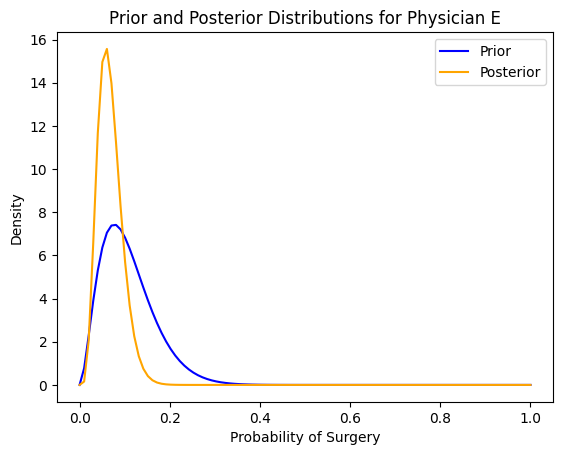

In [63]:
def plot_posterior(physician):
    prior_pdf = stats.beta.pdf(np.linspace(0, 1, 100), a, b)
    posterior_pdf = stats.beta.pdf(np.linspace(0, 1, 100), *(posterior_params(physician)))

    plt.plot(np.linspace(0, 1, 100), prior_pdf, label='Prior', color='blue')
    plt.plot(np.linspace(0, 1, 100), posterior_pdf, label='Posterior', color='orange')
    plt.title(f'Prior and Posterior Distributions for Physician {physician}')
    plt.xlabel('Probability of Surgery')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

plot_posterior('E')

Let's assume that each physician has an unknown true surgery probability which generates new data.\
We can evaluate how the posteriors converge to the unknown value as observations are added.

In [64]:
df['true_p'] = [0.15, 0.25, 0.10, 0.12, 0.05]  # assumed true probabilities

def update_data(physician, new_patients):
    """Generate new data from the true probability"""
    true_p = df.loc[df['physician'] == physician, 'true_p'].values[0]
    new_surgeries = np.random.binomial(new_patients, true_p)
    df.loc[df['physician'] == physician, 'n_patients'] += new_patients
    df.loc[df['physician'] == physician, 'n_surgeries'] += new_surgeries
    df.loc[df['physician'] == physician, 'p_surgery'] = (
        df.loc[df['physician'] == physician, 'n_surgeries'] 
        / df.loc[df['physician'] == physician, 'n_patients']
    )   

In [65]:
class BetaBinomialModel:
    def __init__(self, physician, prior_a, prior_b):
        """Initialize with prior and data for a specific physician"""
        self.physician = physician
        self.data = df.loc[df['physician'] == physician]
        self.n_surgeries = self.data['n_surgeries'].values[0]
        self.n_patients = self.data['n_patients'].values[0]
        self.prior_a = np.round(prior_a, 4)
        self.prior_b = np.round(prior_b, 4)
        self.post_a = np.round(prior_a + self.n_surgeries, 4)
        self.post_b = np.round(prior_b + self.n_patients - self.n_surgeries, 4)
        self.posterior = stats.beta(self.post_a, self.post_b)

    def update(self):
        """Get new data and update posterior"""
        self.data = df.loc[df['physician'] == self.physician]
        self.n_surgeries = self.data['n_surgeries'].values[0]
        self.n_patients = self.data['n_patients'].values[0]
        self.post_a += self.n_surgeries
        self.post_b += (self.n_patients - self.n_surgeries)
        self.posterior = stats.beta(self.post_a, self.post_b)

In [66]:
def plot_updates(model, updates, new_patients_per_update):
    x = np.linspace(0, 1, 100)
    plt.figure(figsize=(10, 6))

    prior_pdf = stats.beta.pdf(x, model.prior_a, model.prior_b)
    plt.plot(x, prior_pdf, label='Prior', color='blue')

    true_p = df.loc[df['physician'] == model.physician, 'true_p'].values[0]
    plt.axvline(true_p, color='red', linestyle='--', label=f'True Probability -- {true_p:.2f}')

    for i in range(updates):

        # Simulate new data
        update_data(model.physician, new_patients_per_update)

        model.update()
        posterior_pdf = stats.beta.pdf(x, model.post_a, model.post_b)
        plt.plot(x, posterior_pdf, label=f'Update {i+1} -- Mean: {model.post_a / (model.post_a + model.post_b):.2f}')

    plt.title(f'Prior and Posterior Updates for Physician {model.physician}')
    plt.xlabel('Probability of Surgery')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

Initial posterior parameters for Physician A: a=3.9055, b=32.9145


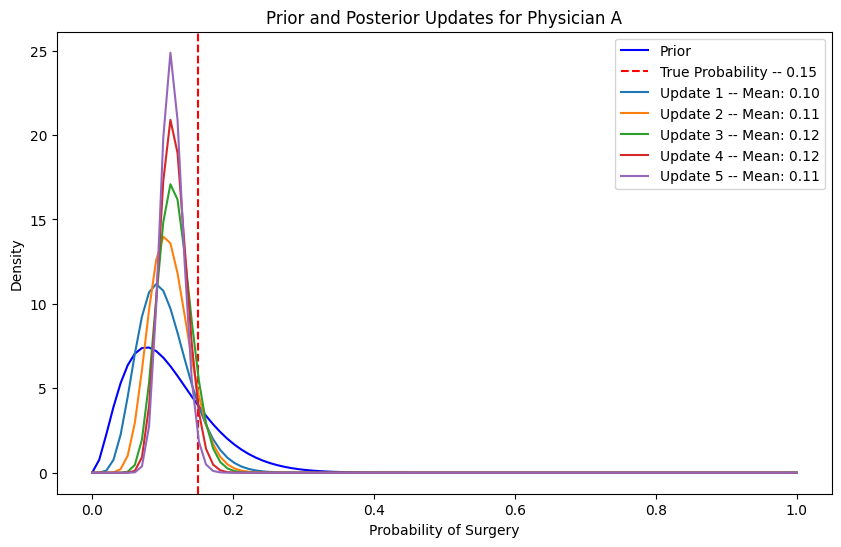

In [67]:
A = BetaBinomialModel('A', a, b)
print(f"Initial posterior parameters for Physician A: a={A.post_a}, b={A.post_b}")

plot_updates(A, updates=5, new_patients_per_update=20)

In [71]:
print(df.loc[df['physician'] == 'A'])

  physician  n_patients  n_surgeries  p_surgery  true_p
0         A         110           12   0.109091    0.15


### Credible Intervals

In [ ]:
def credible_interval(model, alpha: float = 0.05):
    """Get equal-tailed credible interval"""
    lower_bound = model.posterior.ppf(alpha / 2)      # lower-tail quantile
    upper_bound = model.posterior.ppf(1 - alpha / 2)  # upper-tail quantile
    return np.round(lower_bound, 4), np.round(upper_bound, 4)

print(f"95% credible interval for Physician A: {credible_interval(A)}")

95% credible interval for Physician A: (np.float64(0.0839), np.float64(0.1469))
